In [15]:
import torch
import torch.nn as nn
from torchaudio.transforms import MelSpectrogram

from emonet import DATA_DIR, SAMPLE_RATE
from emonet.utils import get_sample, play_audio
from emonet.plots import plot_waveform, plot_spectrogram
from emonet.modules import RandomSegment

In [5]:
FILES = list(DATA_DIR.joinpath('wavs').glob('*.wav'))

file = FILES[73]
sig, _ = get_sample(file, SAMPLE_RATE)

In [33]:
vad_model, vad_utils = torch.hub.load(
    repo_or_dir='snakers4/silero-vad',
    model='silero_vad',
    force_reload=False,
    onnx=False
)

get_speech_timestamps, collect_chunks = vad_utils[0], vad_utils[-1]

class VadChunk(nn.Module):
    def __init__(self, model, sample_rate=SAMPLE_RATE):
        super().__init__()
        self.model = model
        self.sample_rate = sample_rate
    
    def forward(self, x):
        speech = get_speech_timestamps(x, self.model, sampling_rate=self.sample_rate)
        return collect_chunks(speech, x)
        

Using cache found in /Users/chrissantiago/.cache/torch/hub/snakers4_silero-vad_master


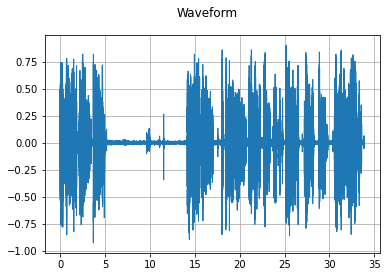

In [12]:
plot_waveform(sig.unsqueeze(0), SAMPLE_RATE)

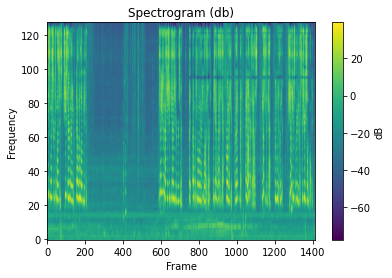

In [26]:
m = nn.Sequential(
    MelSpectrogram(n_mels=128, n_fft=128*6)
)

plot_spectrogram(m(sig))

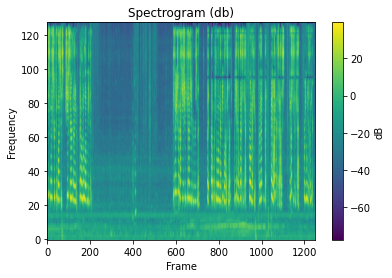

In [27]:
m = nn.Sequential(
    RandomSegment(30),
    MelSpectrogram(n_mels=128, n_fft=128*6)
)

plot_spectrogram(m(sig))

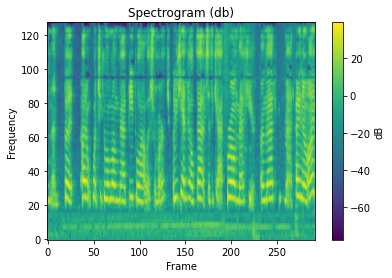

In [34]:
m = nn.Sequential(
    RandomSegment(30),
    VadChunk(vad_model),
    RandomSegment(7),
    MelSpectrogram(n_mels=128, n_fft=128*6)
)

plot_spectrogram(m(sig))

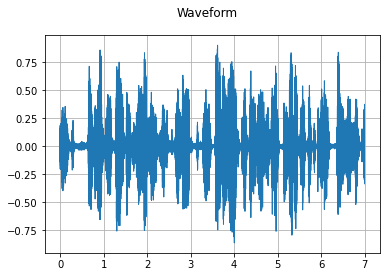

In [36]:
m = nn.Sequential(
    RandomSegment(30),
    VadChunk(vad_model),
    RandomSegment(7),
)

plot_waveform(m(sig).unsqueeze(0), SAMPLE_RATE)